In [ ]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import joblib
import requests
from PIL import Image
from io import BytesIO
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import xgboost as xgb
from tqdm.auto import tqdm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#loading data
train_df = pd.read_csv("train.csv")
train_df.head()

id             date   price  bedrooms  bathrooms  sqft_living  \
0  9117000170  20150505T000000  268643         4       2.25         1810   
1  6700390210  20140708T000000  245000         3       2.50         1600   
2  7212660540  20150115T000000  200000         4       2.50         1720   
3  8562780200  20150427T000000  352499         2       2.25         1240   
4  7760400350  20141205T000000  232000         3       2.00         1280   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      9240     2.0           0     0  ...      7        1810              0   
1      2788     2.0           0     0  ...      7        1600              0   
2      8638     2.0           0     0  ...      8        1720              0   
3       705     2.0           0     0  ...      7        1150             90   
4     13356     1.0           0     0  ...      7        1280              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1961             0    98055  47.4362 -122.187           1660   
1      1992             0    98031  47.4034 -122.187           1720   
2      1994             0    98003  47.2704 -122.313           1870   
3      2009             0    98027  47.5321 -122.073           1240   
4      1994             0    98042  47.3715 -122.074           1590   

   sqft_lot15  
0        9240  
1        3605  
2        7455  
3         750  
4        8071  

[5 rows x 21 columns]

In [4]:
#basic checks
print("Shape:", train_df.shape)
print("\nColumns:\n", train_df.columns)
print("\nData types:\n", train_df.dtypes)

Shape: (16209, 21)

Columns:
 Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Data types:
 id                 int64
date              object
price              int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


In [5]:
#missing values check
train_df.isnull().sum().sort_values(ascending=False)

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# EDA

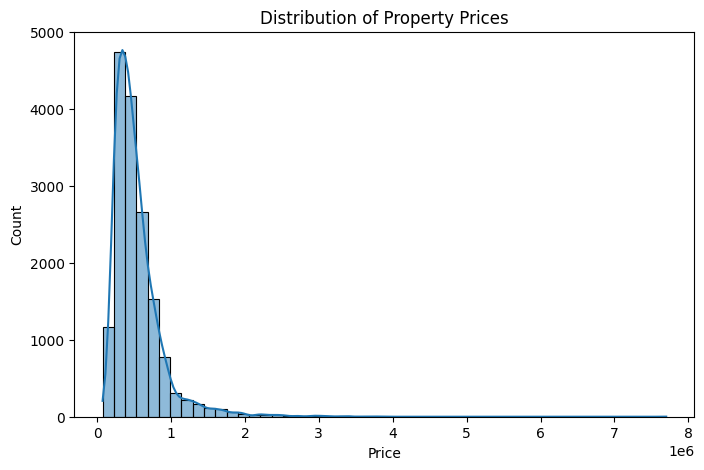

In [6]:
#price distribution
plt.figure(figsize=(8,5))
sns.histplot(train_df["price"], bins=50, kde=True)
plt.title("Distribution of Property Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

In [7]:
#feature columns
num_cols=['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15']

### Core Feature Relationships

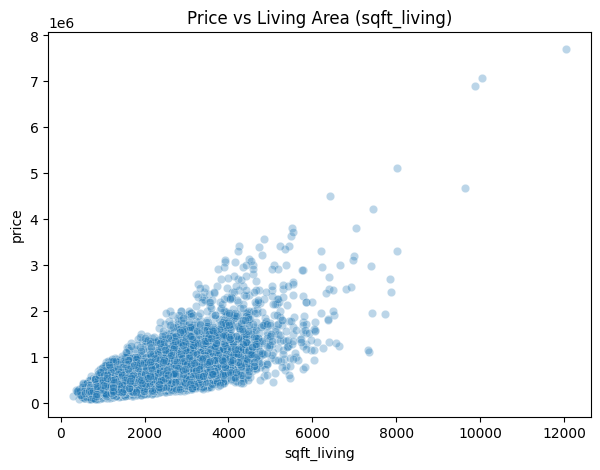

In [8]:
#sqft_living vs price
plt.figure(figsize=(7,5))
sns.scatterplot(x="sqft_living", y="price", data=train_df, alpha=0.3)
plt.title("Price vs Living Area (sqft_living)")
plt.show()

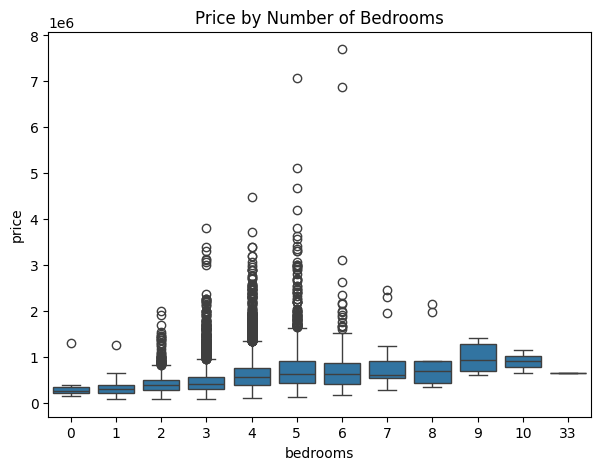

In [9]:
#Bedrooms vs Price
plt.figure(figsize=(7,5))
sns.boxplot(x="bedrooms", y="price", data=train_df)
plt.title("Price by Number of Bedrooms")
plt.show()

In [10]:
#Waterfront Effect
plt.figure(figsize=(6,5))
sns.boxplot(x="waterfront", y="price", data=train_df)
plt.title("Waterfront vs Non-Waterfront Prices")
plt.xticks([0,1], ["No Waterfront", "Waterfront"])
plt.show()

### Correlation Analysis

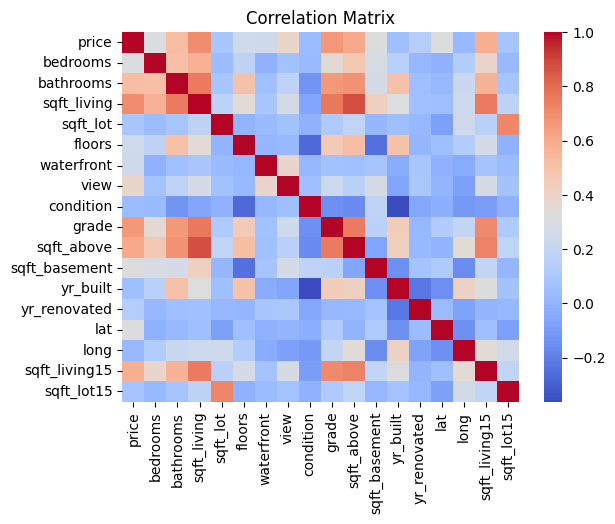

In [11]:
#Correlation Heatmap
corr_matrix = train_df[num_cols].corr()
sns.heatmap(corr_matrix,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="lat", y="price", data=train_df, alpha=0.3)
plt.title("Price vs Latitude")

plt.subplot(1, 2, 2)
sns.scatterplot(x="long", y="price", data=train_df, alpha=0.3)
plt.title("Price vs Longitude")

plt.tight_layout()
plt.show()


### Image Sanity Check

In [13]:
#Sample Properties by Price
low_price = train_df.nsmallest(3, "price")
mid_price = train_df.iloc[len(train_df)//2 - 1: len(train_df)//2 + 2]
high_price = train_df.nlargest(3, "price")

sample_df = pd.concat([low_price, mid_price, high_price])
sample_df[["id", "price"]]

id    price
3656   3421079032    75000
3789   8658300340    80000
16074  3028200080    81000
8103   9809000010  1629000
8104   6303401050   132500
8105   5101402482   520000
4962   6762700020  7700000
1499   9808700762  7062500
2115   9208900037  6885000

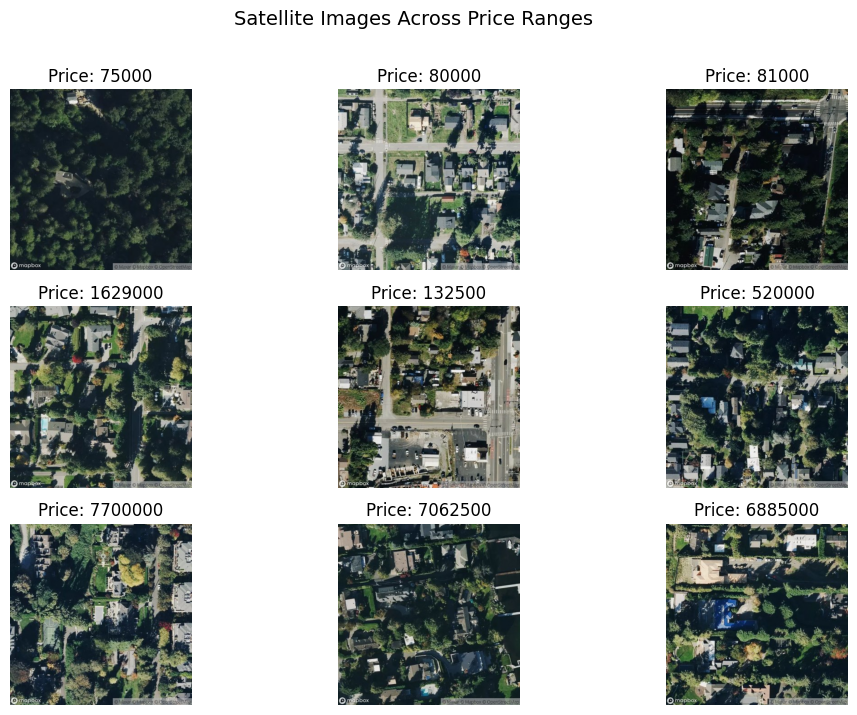

In [14]:
#Display Satellite Images
from PIL import Image

IMAGE_BASE = Path(r"C:\Users\prath\data\images\train")

plt.figure(figsize=(12,8))

for i, row in enumerate(sample_df.itertuples()):
    img_path = IMAGE_BASE / f"{row.id}.png"

    if img_path.exists():
        img = Image.open(img_path)
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(f"Price: {int(row.price)}")
        plt.axis("off")

plt.suptitle("Satellite Images Across Price Ranges", fontsize=14)
plt.show()

# Preprocessing 

In [15]:
# data loading
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(train_df.shape, test_df.shape)

(16209, 21) (5404, 20)


In [16]:
CURRENT_YEAR = 2020

def add_engineered_features(df):

    df = df.copy()
    
    df["house_age"] = CURRENT_YEAR - df["yr_built"]
    
    df["years_since_reno"] = np.where(
        df["yr_renovated"] == 0,
        0,
        CURRENT_YEAR - df["yr_renovated"]
    )
    
    return df


In [17]:
train = add_engineered_features(train_df)
test  = add_engineered_features(test_df)

In [18]:
FEATURES = [
    "bedrooms","bathrooms","sqft_living","sqft_lot","floors",
    "waterfront","view","condition","grade",
    "sqft_above","sqft_basement",
    "house_age","years_since_reno",
    "lat","long",
    "sqft_living15","sqft_lot15"
]

TARGET = "price"


In [19]:
X = train[FEATURES].copy()
y = train[TARGET].copy()

X_test = test[FEATURES].copy()


In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
)


In [21]:
xgb_model = xgb.XGBRegressor(
    n_estimators = 600,
    learning_rate = 0.05,
    max_depth = 8,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = "reg:squarederror",
    random_state = 42,
    n_jobs = -1
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=-1, num_parallel_tree=None, ...)

In [22]:
val_pred = xgb_model.predict(X_val)

rmse_xgb = np.sqrt(mean_squared_error(y_val, val_pred))
mae_xgb  = mean_absolute_error(y_val, val_pred)
r2_xgb   = r2_score(y_val, val_pred)

print(f"RMSE: {rmse_xgb:,.3f}")
print(f"MAE : {mae_xgb:,.3f}")
print(f"R²  : {r2_xgb:.4f}")


RMSE: 117,430.147
MAE : 66,420.266
R²  : 0.8901


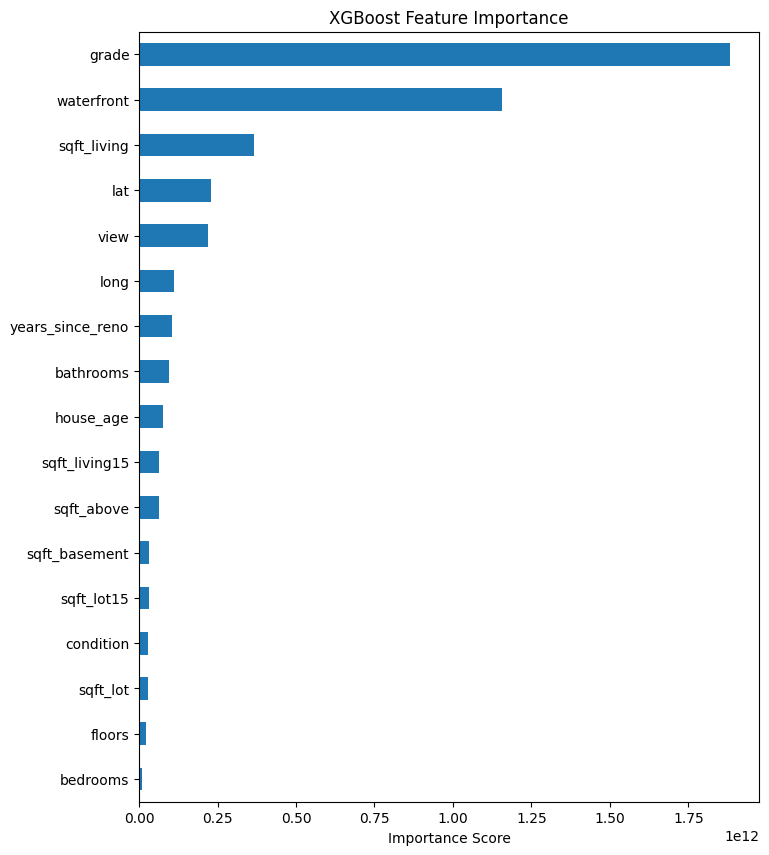

In [23]:
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance = pd.Series(importance).sort_values()

plt.figure(figsize=(8,10))
importance.plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.show()


In [24]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_val, y=val_pred, alpha=0.4)

# perfect prediction line
lims = [min(y_val.min(), val_pred.min()), max(y_val.max(), val_pred.max())]
plt.plot(lims, lims, 'r--')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices (Validation Set)")
plt.show()


In [25]:
#saving model
joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']

# CNN Model

In [26]:
# path and config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

BATCH_SIZE = 16
EPOCHS = 10
LR = 3e-4
IMG_DIR = "data/images/train"


Using device: cuda


In [27]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [28]:
# dataset class
class HouseImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = Path(image_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.image_dir / f"{row['id']}.png"
        
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        price = torch.tensor(row["price"] / 1e6, dtype=torch.float32)

        return image, price

In [29]:
df = pd.read_csv("train.csv")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)


In [30]:
train_ds = HouseImageDataset(train_df, IMG_DIR, train_transform)
val_ds   = HouseImageDataset(val_df,   IMG_DIR, val_transform)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=0, pin_memory=True)

val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=True)

In [31]:
#CNN Model (ResNet18 Regression)
class CNNPriceModel(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()

        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        n = self.backbone.fc.in_features

        self.backbone.fc = nn.Sequential(
            nn.Linear(n, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.backbone(x).squeeze(1)

In [32]:
model = CNNPriceModel().to(DEVICE)

In [33]:
# Loss and optimizer and scheduler
criterion = nn.MSELoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dl),
    pct_start=0.1,
    anneal_strategy="cos"
)

In [34]:
# train function 
def train_epoch():
    model.train()
    total_loss = 0

    for imgs, prices in tqdm(train_dl, desc="Training"):
        imgs = imgs.to(DEVICE)
        prices = prices.to(DEVICE)

        preds = model(imgs)
        loss = criterion(preds, prices)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item() * len(imgs)

    return total_loss / len(train_dl.dataset)

In [35]:
# validation function
def eval_epoch():
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for imgs, prices in tqdm(val_dl, desc="Validation"):
            imgs = imgs.to(DEVICE)
            prices = prices.to(DEVICE)

            outputs = model(imgs)

            preds.extend(outputs.cpu().numpy())
            trues.extend(prices.cpu().numpy())

    preds = np.array(preds) * 1e6
    trues = np.array(trues) * 1e6

    rmse = np.sqrt(mean_squared_error(trues, preds))
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)

    return rmse, mae, r2


In [36]:
# training loop
best_rmse = float("inf")

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")
    
    train_loss = train_epoch()
    rmse, mae, r2 = eval_epoch()

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val RMSE : ${rmse:,.0f}")
    print(f"Val MAE  : ${mae:,.0f}")
    print(f"Val R²   : {r2:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        torch.save(model.state_dict(), "best_cnn_model.pth")
        print("✅ Saved best model")
        



===== Epoch 1/10 =====


Validation: 100%|██████████| 203/203 [00:20<00:00, 10.15it/s]


Train Loss: 0.3564
Val RMSE : $354,198
Val MAE  : $220,120
Val R²   : 0.0003
✅ Saved best model

===== Epoch 2/10 =====


Validation: 100%|██████████| 203/203 [00:20<00:00, 10.06it/s]


Train Loss: 0.1143
Val RMSE : $313,450
Val MAE  : $181,107
Val R²   : 0.2171
✅ Saved best model

===== Epoch 3/10 =====


Validation: 100%|██████████| 203/203 [00:21<00:00,  9.32it/s]


Train Loss: 0.0958
Val RMSE : $301,118
Val MAE  : $170,215
Val R²   : 0.2774
✅ Saved best model

===== Epoch 4/10 =====


Validation: 100%|██████████| 203/203 [00:21<00:00,  9.36it/s]


Train Loss: 0.0859
Val RMSE : $326,195
Val MAE  : $195,097
Val R²   : 0.1521

===== Epoch 5/10 =====


Validation: 100%|██████████| 203/203 [00:19<00:00, 10.25it/s]


Train Loss: 0.0794
Val RMSE : $255,608
Val MAE  : $157,735
Val R²   : 0.4794
✅ Saved best model

===== Epoch 6/10 =====


Validation: 100%|██████████| 203/203 [00:25<00:00,  7.83it/s]


Train Loss: 0.0713
Val RMSE : $361,035
Val MAE  : $172,523
Val R²   : -0.0387

===== Epoch 7/10 =====


Validation: 100%|██████████| 203/203 [00:29<00:00,  6.81it/s]


Train Loss: 0.0638
Val RMSE : $268,726
Val MAE  : $152,034
Val R²   : 0.4245

===== Epoch 8/10 =====


Validation: 100%|██████████| 203/203 [00:26<00:00,  7.77it/s]


Train Loss: 0.0540
Val RMSE : $264,683
Val MAE  : $152,819
Val R²   : 0.4417

===== Epoch 9/10 =====


Validation: 100%|██████████| 203/203 [00:49<00:00,  4.07it/s]


Train Loss: 0.0466
Val RMSE : $262,650
Val MAE  : $148,969
Val R²   : 0.4503

===== Epoch 10/10 =====


Validation: 100%|██████████| 203/203 [00:48<00:00,  4.17it/s]


Train Loss: 0.0433
Val RMSE : $251,689
Val MAE  : $146,769
Val R²   : 0.4952
✅ Saved best model


In [36]:
model.load_state_dict(torch.load("best_cnn_model.pth", map_location=DEVICE))
model.to(DEVICE)

CNNPriceModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [37]:
rmse, mae, r2 = eval_epoch()

print(" FINAL IMAGE-ONLY MODEL RESULTS ")

print(f"RMSE : ${rmse:,.0f}")
print(f"MAE  : ${mae:,.0f}")
print(f"R²   : {r2:.4f}")


Validation: 100%|██████████| 203/203 [00:21<00:00,  9.64it/s]

 FINAL IMAGE-ONLY MODEL RESULTS 
RMSE : $251,689
MAE  : $146,769
R²   : 0.4952


In [38]:
model.eval()

all_preds = []
all_trues = []

with torch.no_grad():
    for imgs, prices in tqdm(val_dl, desc="Collecting predictions"):
        imgs = imgs.to(DEVICE)

        outputs = model(imgs).cpu().numpy()   # normalized 0–1
        prices = prices.cpu().numpy()         # normalized 0–1

        all_preds.extend(outputs)
        all_trues.extend(prices)

all_preds = np.array(all_preds) * 1e6   # convert once
all_trues = np.array(all_trues) * 1e6

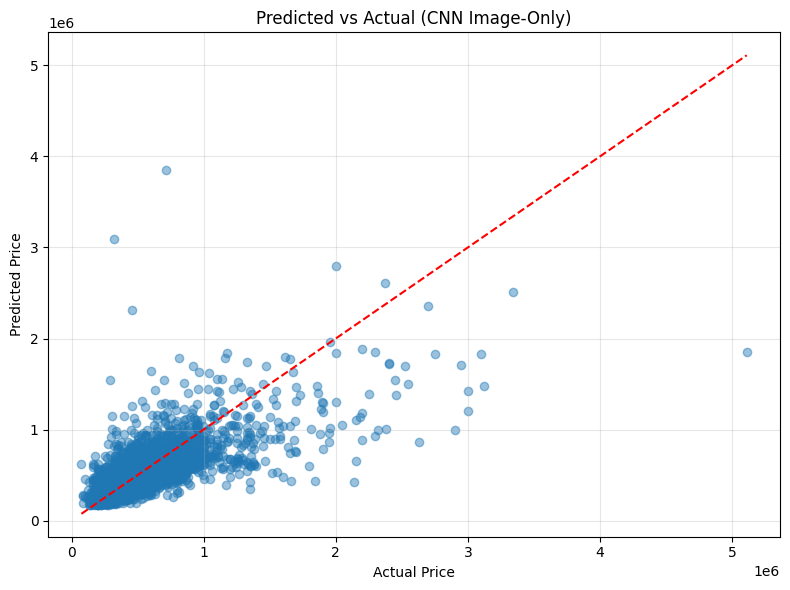

In [39]:
#predictions vs Actual Plot
plt.figure(figsize=(8,6))
plt.scatter(all_trues, all_preds, alpha=0.45)

mn = min(all_trues.min(), all_preds.min())
mx = max(all_trues.max(), all_preds.max())
plt.plot([mn,mx], [mn,mx], "r--")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual (CNN Image-Only)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [40]:
print("\nSample Predictions:\n")
for i in range(10):
    print(f"Actual: ${all_trues[i]:,.0f}   Pred: ${all_preds[i]:,.0f}")



Sample Predictions:

Actual: $612,000   Pred: $579,201
Actual: $392,000   Pred: $560,184
Actual: $399,888   Pred: $478,850
Actual: $385,000   Pred: $542,820
Actual: $235,000   Pred: $421,896
Actual: $390,000   Pred: $277,007
Actual: $485,000   Pred: $547,298
Actual: $1,695,000   Pred: $1,090,384
Actual: $650,000   Pred: $552,602
Actual: $275,000   Pred: $240,325


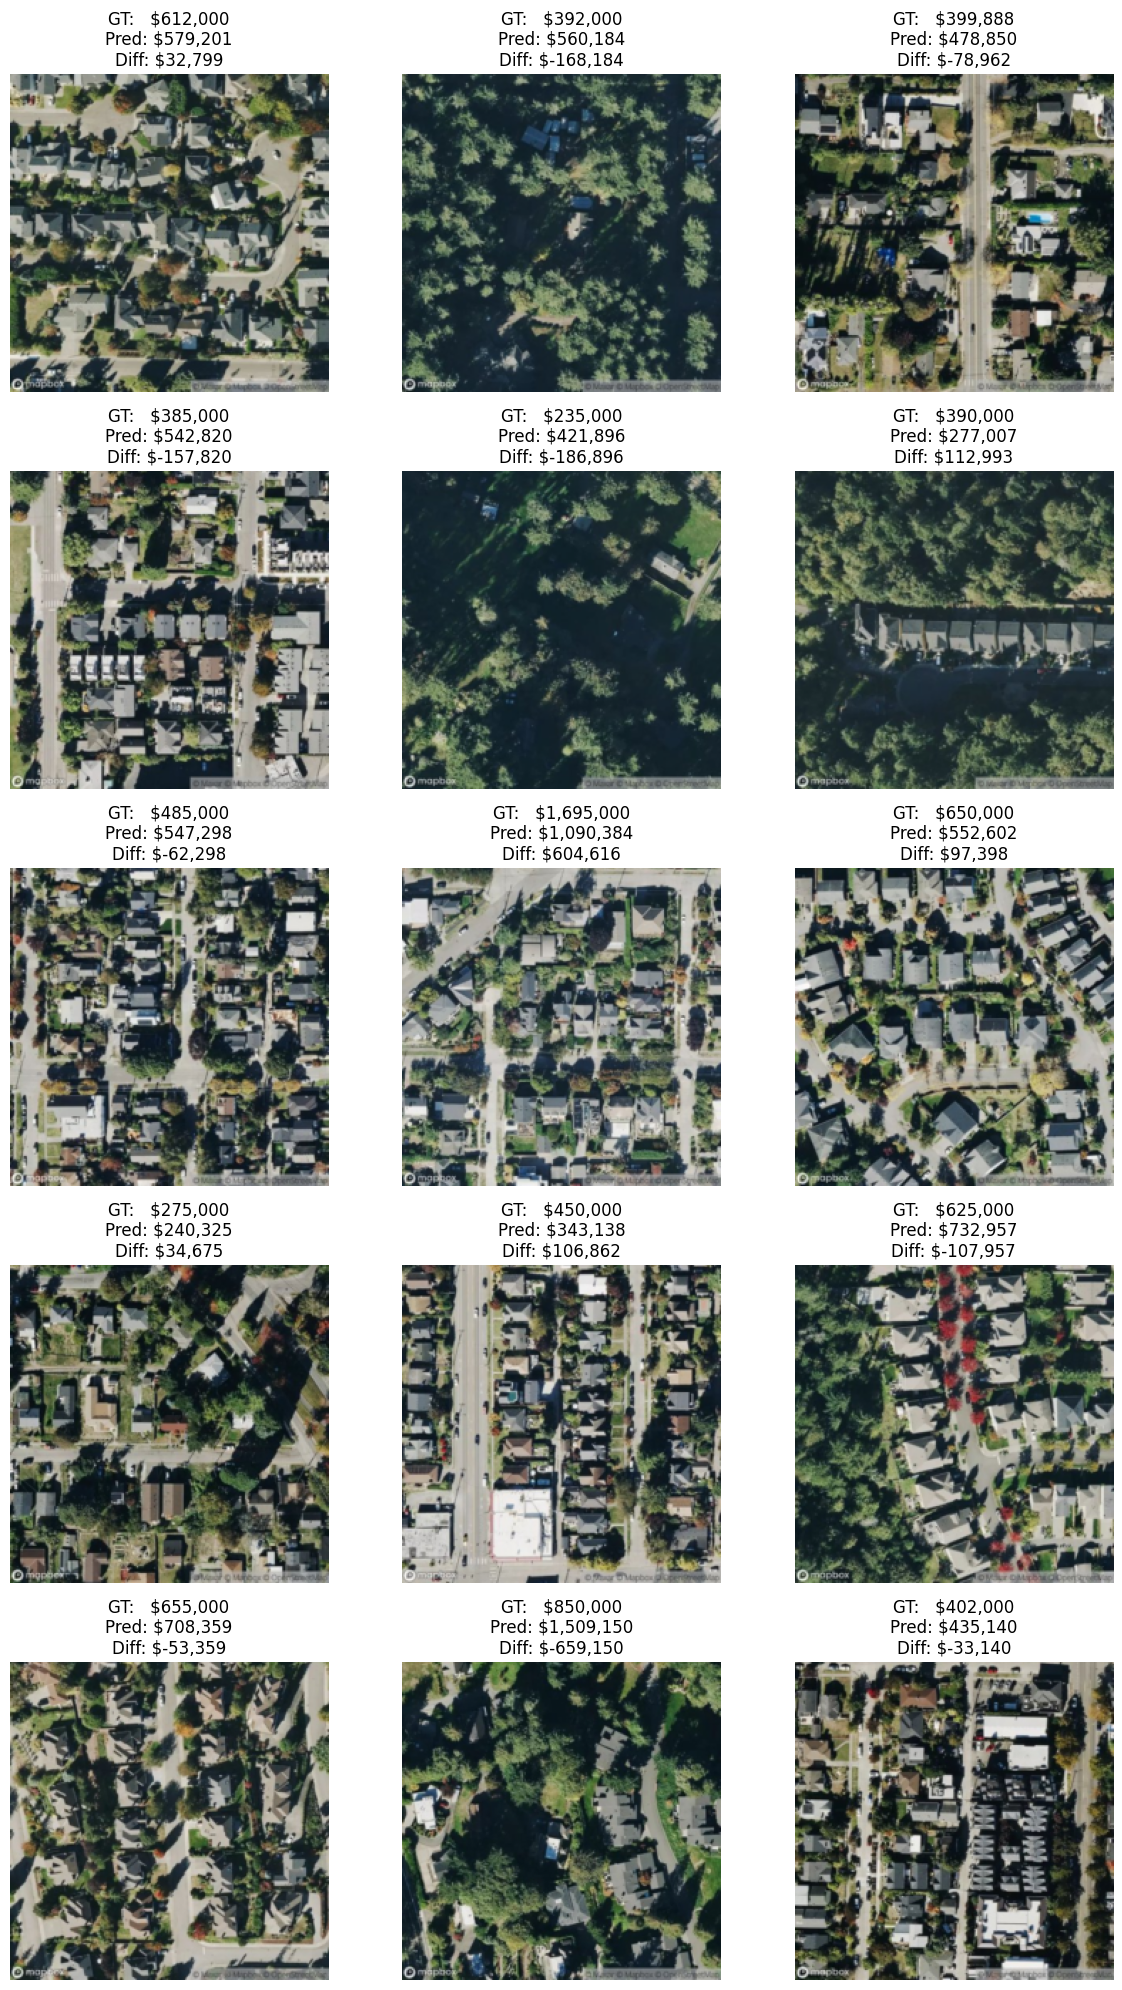

In [41]:
model.eval()

images, targets = next(iter(val_dl))

with torch.no_grad():
    preds = model(images.to(DEVICE)).cpu().numpy()

fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for i, ax in enumerate(axes.flat):
    if i >= len(images):
        break

    img = images[i].clone()

    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)

    ax.imshow(img)

    gt  = targets[i].item() * 1e6
    pr  = preds[i] * 1e6
    diff = gt - pr

    ax.set_title(
        f"GT:   ${gt:,.0f}\n"
        f"Pred: ${pr:,.0f}\n"
        f"Diff: ${diff:,.0f}"
    )

    ax.axis("off")

plt.tight_layout()
plt.show()


# Multimodal Fusion Model 

In [42]:
# load XGB model
xgb_model = joblib.load("xgb_model.pkl")

In [43]:
# load CNN best weights
model.load_state_dict(torch.load("best_cnn_model.pth", map_location=DEVICE))
model.eval()

CNNPriceModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [44]:
y_pred_xgb = xgb_model.predict(X_val)
y_pred_xgb = np.array(y_pred_xgb)

In [45]:
cnn_preds = []

with torch.no_grad():
    for imgs, _ in val_dl:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).cpu().numpy()
        cnn_preds.extend(preds)

y_pred_cnn = np.array(cnn_preds)

In [46]:
y_pred_cnn = y_pred_cnn * 1e6


In [47]:
X_fusion = np.column_stack([y_pred_xgb, y_pred_cnn])
fusion_model = LinearRegression()

fusion_model.fit(X_fusion, y_val)

y_pred_fusion = fusion_model.predict(X_fusion)


In [48]:
rmse_fusion = np.sqrt(mean_squared_error(y_val, y_pred_fusion))
mae_fusion  = mean_absolute_error(y_val, y_pred_fusion)
r2_fusion   = r2_score(y_val, y_pred_fusion)

print(f"Fusion RMSE : ${rmse_fusion:,.0f}")
print(f"Fusion MAE  : ${mae_fusion:,.0f}")
print(f"Fusion R²   : {r2_fusion:.4f}")


Fusion RMSE : $115,442
Fusion MAE  : $66,528
Fusion R²   : 0.8938


In [49]:
joblib.dump(fusion_model, "fusion_xgb_cnn.pkl")

['fusion_xgb_cnn.pkl']

# Model Comparison

In [50]:
results_df = pd.DataFrame({
    "Model": [
        "XGBoost (Tabular)",
        "CNN (Image Only)",
        "Fusion (XGB + CNN)"
    ],
    "RMSE": [
        rmse_xgb,
        rmse,
        rmse_fusion
    ],
    "R² Score": [
        r2_xgb,
        r2,
        r2_fusion
    ]
})

results_df


Model           RMSE  R² Score
0   XGBoost (Tabular)  117430.146726  0.890111
1    CNN (Image Only)  251689.412666  0.495193
2  Fusion (XGB + CNN)  115441.879403  0.893800

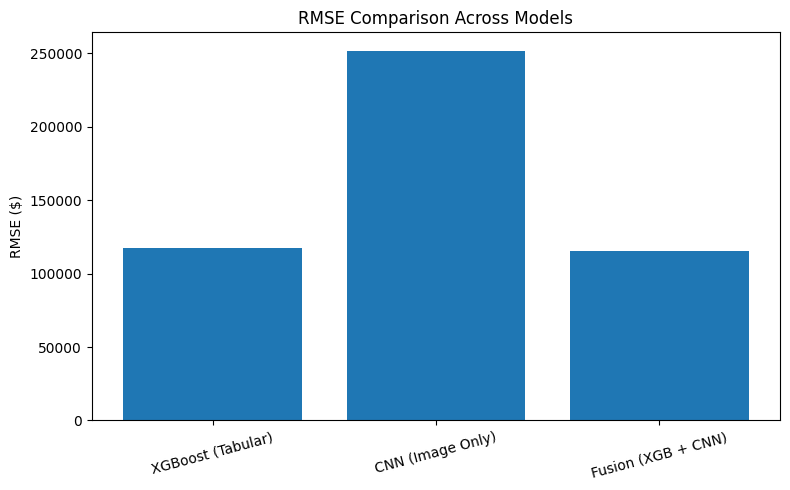

In [51]:
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["RMSE"])
plt.ylabel("RMSE ($)")
plt.title("RMSE Comparison Across Models")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

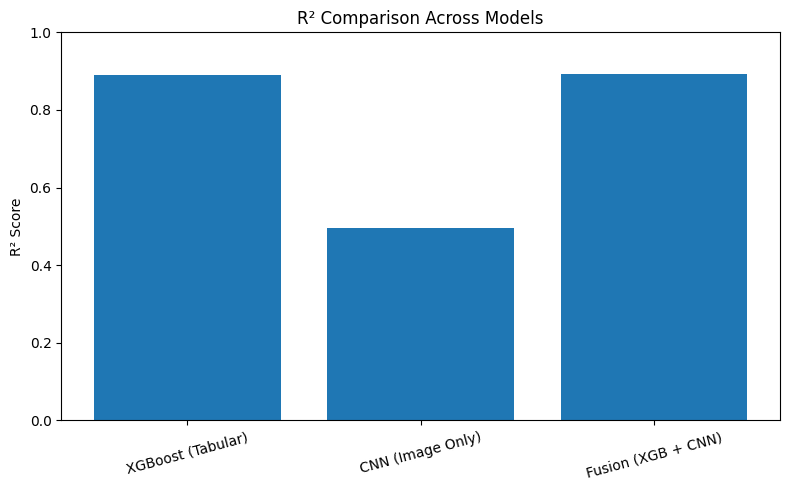

In [52]:
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["R² Score"])
plt.ylabel("R² Score")
plt.title("R² Comparison Across Models")
plt.xticks(rotation=15)
plt.ylim(0,1)
plt.tight_layout()
plt.show()


# Test Variables 

In [53]:
# load data
test_df = pd.read_csv("test.csv")

test_df["house_age"] = 2020 - test_df["yr_built"]
test_df["years_since_reno"] = np.where(
    test_df["yr_renovated"] > 0,
    2020 - test_df["yr_renovated"],
    0
)

X_test = test_df[FEATURES]


In [54]:
test_pred_xgb = xgb_model.predict(X_test)

In [55]:
class HouseTestDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = Path(image_dir)
        self.transform = transform
        
        self.valid_indices = []
        print("Checking for valid images...")
        for i in range(len(self.df)):
            img_path = self.image_dir / f"{self.df.iloc[i]['id']}.png"
            if img_path.exists():
                self.valid_indices.append(i)
        print(f"✓ Found {len(self.valid_indices)}/{len(self.df)} valid images")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        row = self.df.iloc[real_idx]
        img_path = self.image_dir / f"{row['id']}.png"

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, row["id"]


In [56]:
TEST_IMG_DIR = "data/images/test"

test_ds = HouseTestDataset(
    test_df,
    TEST_IMG_DIR,
    val_transform
)

test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


Checking for valid images...
✓ Found 5334/5404 valid images


In [57]:
test_pred_cnn = []

model.eval()

with torch.no_grad():
    for images, _ in test_dl:
        images = images.to(DEVICE)
        preds = model(images).cpu().numpy()
        test_pred_cnn.extend(preds)

test_pred_cnn = np.array(test_pred_cnn)


In [58]:
test_df["cnn_pred"] = np.nan


In [59]:
for idx, pred in zip(test_ds.valid_indices, test_pred_cnn):
    test_df.loc[idx, "cnn_pred"] = pred


In [60]:
fusion_mask = test_df["cnn_pred"].notna()

X_test_fusion = np.column_stack([
    test_pred_xgb[fusion_mask],
    test_df.loc[fusion_mask, "cnn_pred"].values
])


In [61]:
fusion_preds = fusion_model.predict(X_test_fusion)


In [62]:
test_df["final_price"] = test_pred_xgb


In [63]:
test_df.loc[fusion_mask, "final_price"] = fusion_preds


In [75]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": test_df["final_price"]
})

submission.to_csv("submission.csv", index=False)

print("submission.csv saved 🎯")


submission.csv saved 🎯


# Explainability with Grad-CAM

In [ ]:
class RegressionTarget:
    def __init__(self, output_index=0):
        self.output_index = output_index

    def __call__(self, model_output):
        if model_output.ndim == 0:
            return model_output.unsqueeze(0)
        if model_output.ndim == 1:
            return model_output
        return model_output[:, self.output_index]



In [110]:
target_layers = [model.backbone.layer4[-1]]


In [111]:
def generate_cam(image):

    input_tensor = preprocess(image)

    cam = GradCAM(model=model, target_layers=target_layers)

    grayscale_cam = cam(
        input_tensor=input_tensor,
        targets=[RegressionTarget(0)]
    )[0]

    rgb_img = np.float32(image.resize((224,224))) / 255.0

    visualization = show_cam_on_image(
        rgb_img,
        grayscale_cam,
        use_rgb=True
    )

    return visualization

In [113]:
low_ids  = submission.sort_values("predicted_price").head(5)["id"].values
mid_ids  = submission.sample(5, random_state=42)["id"].values
high_ids = submission.sort_values("predicted_price").tail(5)["id"].values


In [114]:
def visualize_list(id_list, title):
    plt.figure(figsize=(14,10))

    for i, id_value in enumerate(id_list):
        img = load_image_by_id(id_value)
        cam_img = generate_cam(img)

        plt.subplot(2,3,i+1)
        plt.imshow(cam_img)
        plt.axis("off")
        plt.title(f"id={id_value}")

    plt.suptitle(title, fontsize=16)
    plt.show()


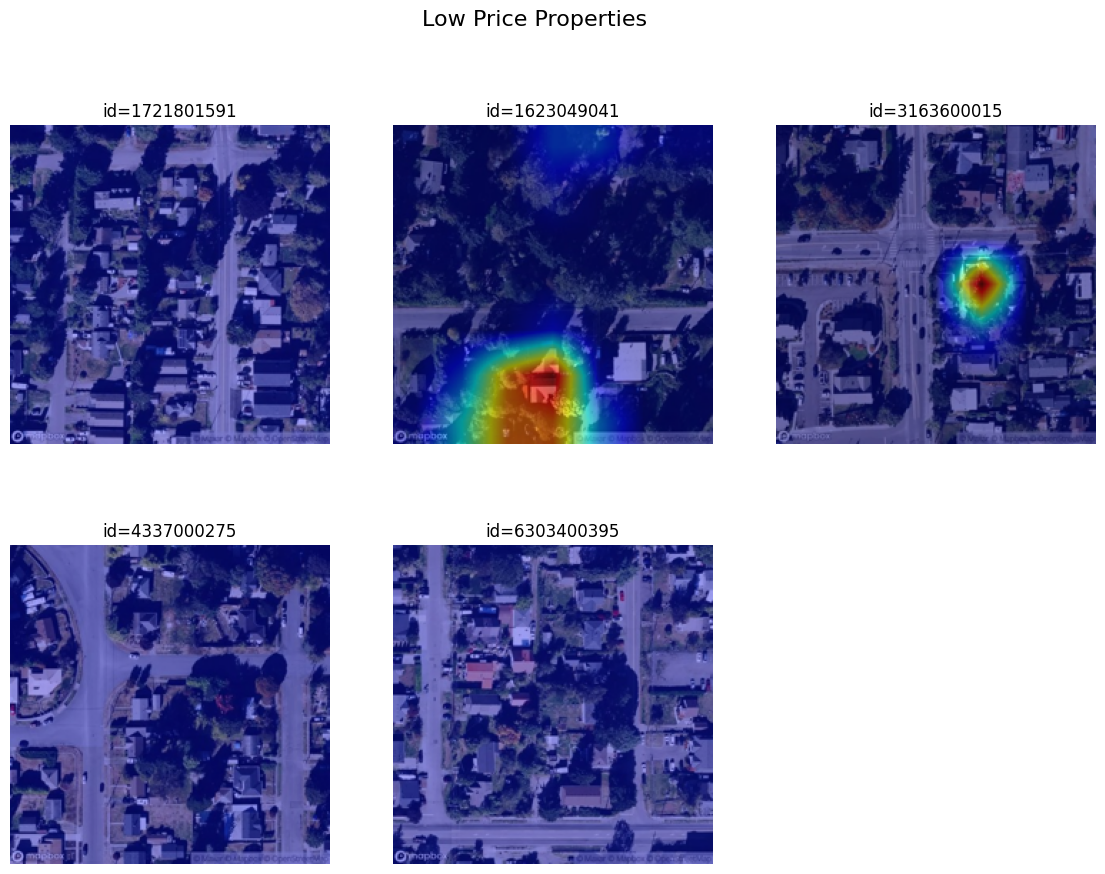

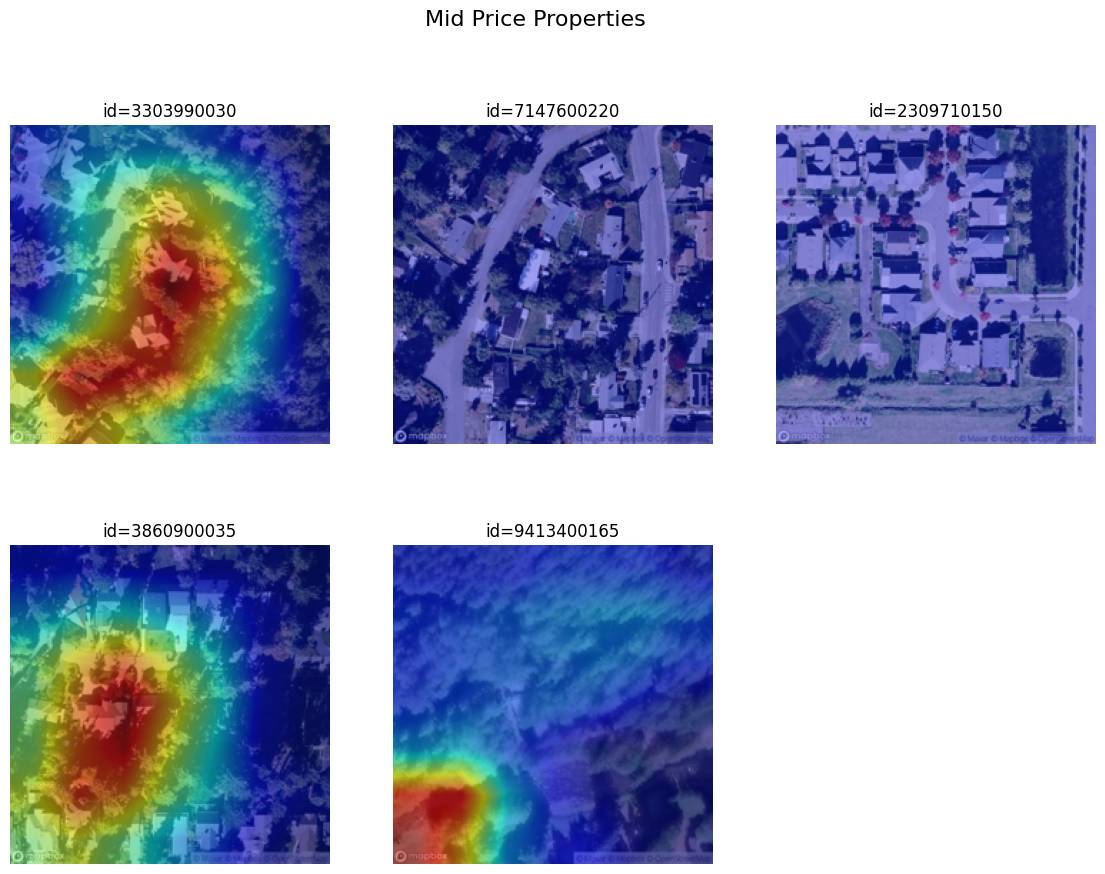

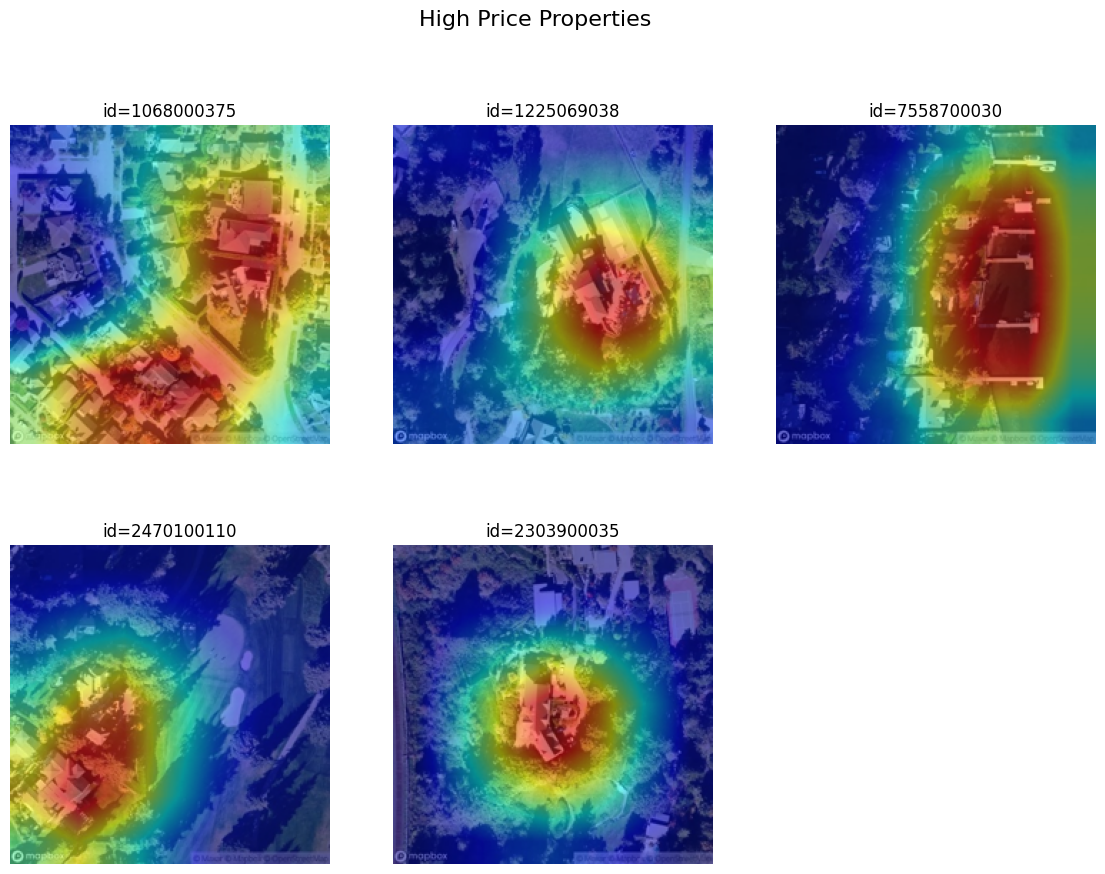

In [115]:
visualize_list(low_ids,  "Low Price Properties")
visualize_list(mid_ids,  "Mid Price Properties")
visualize_list(high_ids, "High Price Properties")
